In [1]:
import gym

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import random
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from matplotlib.colors import LogNorm
import pickle

from joblib import Parallel, delayed
import multiprocessing
from collections import namedtuple
from itertools import count

import cProfile
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

from matplotlib import rc
# rc('font',**{'family':'sans-serif'})
# rc('text', usetex=True)
# rc('text.latex',preamble=r'\usepackage[utf8]{inputenc}')
# rc('text.latex',preamble=r'\usepackage[russian]{babel}')
# rc('figure', **{'dpi': 300})

from time import sleep

from tqdm import tqdm
import pandas as pd

from collections import defaultdict

import random

/Library/Python/3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
#         self.weights = np.ones(shape=(self.capacity)) / self.capacity

    def store(self, exptuple):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = exptuple
#         self.weights[self.position] = 1 / self.capacity
        self.position = (self.position + 1) % self.capacity
        
#     def set_weights(self, weights):
#         self.weights = np.array(weights)
#         self.weights = self.weights / self.weights.sum()
       
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
#         return np.random.choice(self.memory, size=batch_size, p=self.weights / self.weights.sum())
    
    def __len__(self):
        return len(self.memory)

class Network(nn.Module):
    def __init__(self, layer_size=256):
        nn.Module.__init__(self)
        self.l1 = nn.Linear(4, layer_size)
        self.l2 = nn.Linear(layer_size, 2)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = self.l2(x)
        return x

def plot_durations(xs, labels):
    plt.figure(figsize=(10, 5))
    plt.xlabel('РќРѕРјРµСЂ СЌРїРёР·РѕРґР°')
    plt.ylabel('Р§РёСЃР»Рѕ С€Р°РіРѕРІ')
    for i,x in enumerate(xs):
        plt.plot(x, label=labels[i])
    plt.legend(loc="upper left")

class CartpoleDQN():
    def __init__(self):
        self.env = gym.make('CartPole-v0')
        self.model = Network()
        self.memory = ReplayMemory(10000)
        self.optimizer = optim.Adam(self.model.parameters(), 0.001)
        self.steps_done = 0
        self.episode_durations = []
        
        self.gamma = 0.8
        self.batch_size = 64
        
        self.eps_init, self.eps_final, self.eps_decay = 0.9, 0.05, 200
        self.num_step = 0

    def select_greedy_action(self, state):
        return self.model(state).data.max(1)[1].view(1, 1)

    def select_action(self, state):
        sample = random.random()
        self.num_step += 1
        eps_threshold = self.eps_final + (self.eps_init - self.eps_final) * math.exp(-1. * self.num_step / self.eps_decay)
        if sample > eps_threshold:
            return self.select_greedy_action(state)
        else:
            return torch.tensor([[random.randrange(2)]], dtype=torch.int64)
        
    def run_episode(self, e=0, do_learning=True, greedy=False, render=False):
        state, num_step = self.env.reset(), 0
        while True:
            if render:
                self.env.render()

            state_tensor = torch.tensor([state], dtype=torch.float32)
            with torch.no_grad():
                if greedy:
                    action = self.select_greedy_action(state_tensor)
                else:
                    action = self.select_action(state_tensor)
            next_state, reward, done, _ = self.env.step(action.numpy()[0][0])
            next_state_tensor = torch.tensor([next_state], dtype=torch.float32)

            if done:
                reward = -1

            transition = (state_tensor, action, next_state_tensor, torch.tensor([reward], dtype=torch.float32))
            self.memory.store(transition)

            if do_learning:
                self.learn()

            state = next_state
            num_step += 1

            if done:
                print("\tepisode %d finished after %d steps" % (e, num_step))
                self.episode_durations.append(num_step)
                break

    def learn(self):
        if len(self.memory) < self.batch_size:
            return

        # Р±РµСЂС‘Рј РјРёРЅРё-Р±Р°С‚С‡ РёР· РїР°РјСЏС‚Рё
        transitions = self.memory.sample(self.batch_size)
        batch_state, batch_action, batch_next_state, batch_reward = zip(*transitions)

        batch_state = Variable(torch.cat(batch_state))
        batch_action = Variable(torch.cat(batch_action))
        batch_reward = Variable(torch.cat(batch_reward))
        batch_next_state = Variable(torch.cat(batch_next_state))

        # СЃС‡РёС‚Р°РµРј Р·РЅР°С‡РµРЅРёСЏ С„СѓРЅРєС†РёРё Q
        Q = self.model(batch_state).gather(1, batch_action).reshape([self.batch_size])

        # РѕС†РµРЅРёРІР°РµРј РѕР¶РёРґР°РµРјС‹Рµ Р·РЅР°С‡РµРЅРёСЏ РїРѕСЃР»Рµ СЌС‚РѕРіРѕ РґРµР№СЃС‚РІРёСЏ
        Qmax = self.model(batch_next_state).detach().max(1)[0]
        Qnext = batch_reward + (self.gamma * Qmax)

        # Рё С…РѕС‚РёРј, С‡С‚РѕР±С‹ Q Р±С‹Р»Рѕ РїРѕС…РѕР¶Рµ РЅР° Qnext -- СЌС‚Рѕ Рё РµСЃС‚СЊ СЃСѓС‚СЊ Q-РѕР±СѓС‡РµРЅРёСЏ
        loss = F.smooth_l1_loss(Q, Qnext)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [3]:
from IPython.display import clear_output

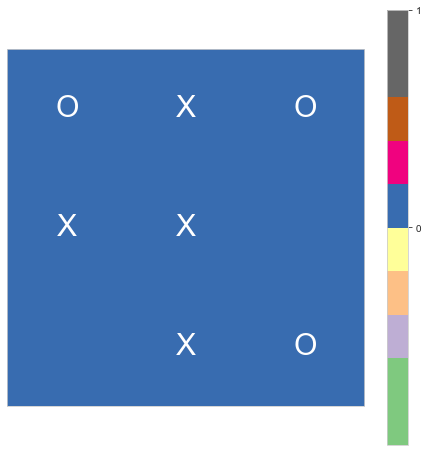

crosses win! 1


In [4]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3

class TicTacToe(gym.Env):
    def __init__(self, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_win = n_win

        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.gameOver = False
        self.boardHash = None
        # С…РѕРґ РїРµСЂРІРѕРіРѕ РёРіСЂРѕРєР°
        self.curTurn = 1
        self.emptySpaces = None
        
        self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def isTerminal(self):
        # РїСЂРѕРІРµСЂРёРј, РЅРµ Р·Р°РєРѕРЅС‡РёР»Р°СЃСЊ Р»Рё РёРіСЂР°
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i,j in zip(cur_marks[0], cur_marks[1]):
#             print((i,j))
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i,j:j+self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                    if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1
        return self.getState()

def plot_board(env, pi, showtext=True, verbose=True, fontq=20, fontx=60):
    clear_output(wait=True)
    '''Р РёСЃСѓРµРј РґРѕСЃРєСѓ СЃ РѕС†РµРЅРєР°РјРё РёР· СЃС‚СЂР°С‚РµРіРёРё pi'''
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    X, Y = np.meshgrid(np.arange(0, env.n_rows), np.arange(0, env.n_rows))
    Z = np.zeros((env.n_rows, env.n_cols)) + .01
    s, actions = env.getHash(), env.getEmptySpaces()
    if pi is not None and s in pi.Q:
        for i, a in enumerate(actions):
            Z[a[0], a[1]] = pi.Q[s][i]
    ax.set_xticks([])
    ax.set_yticks([])
    surf = ax.imshow(Z, cmap=plt.get_cmap('Accent', 10), vmin=-1, vmax=1)
    if showtext:
        for i,a in enumerate(actions):
            if pi is not None and s in pi.Q:
                ax.text( a[1] , a[0] , "%.3f" % pi.Q[s][i], fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
#             else:
#                 ax.text( a[1] , a[0] , "???", fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
    for i in range(env.n_rows):
        for j in range(env.n_cols):
            if env.board[i, j] == -1:
                ax.text(j, i, "O", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
            if env.board[i, j] == 1:
                ax.text(j, i, "X", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
    cbar = plt.colorbar(surf, ticks=[0, 1])
    ax.grid(False)
    plt.show()

def get_and_print_move(env, pi, s, actions, random=False, verbose=True, fontq=20, fontx=60):
    '''Р”РµР»Р°РµРј С…РѕРґ, СЂРёСЃСѓРµРј РґРѕСЃРєСѓ'''
    plot_board(env, pi, fontq=fontq, fontx=fontx)
    if verbose and (pi is not None):
        if s in pi.Q:
            for i,a in enumerate(actions):
                print(i, a, pi.Q[s][i])
        else:
            print("РЎС‚СЂР°С‚РµРіРёСЏ РЅРµ Р·РЅР°РµС‚, С‡С‚Рѕ РґРµР»Р°С‚СЊ...")
    if random:
        return np.random.randint(len(actions))
    else:
        return pi.getActionGreedy(s, len(actions))

def plot_test_game(env, pi1, pi2, random_crosses=False, random_naughts=True, verbose=True, fontq=20, fontx=60):
    '''РРіСЂР°РµРј С‚РµСЃС‚РѕРІСѓСЋ РїР°СЂС‚РёСЋ РјРµР¶РґСѓ СЃС‚СЂР°С‚РµРіРёСЏРјРё РёР»Рё СЃРѕ СЃР»СѓС‡Р°Р№РЅС‹РјРё С…РѕРґР°РјРё, СЂРёСЃСѓРµРј С…РѕРґ РёРіСЂС‹'''
    done = False
    env.reset()
    while not done:
        s, actions = env.getHash(), env.getEmptySpaces()
        if env.curTurn == 1:
            a = get_and_print_move(env, pi1, s, actions, random=random_crosses, verbose=verbose, fontq=fontq, fontx=fontx)
        else:
            a = get_and_print_move(env, pi2, s, actions, random=random_naughts, verbose=verbose, fontq=fontq, fontx=fontx)
        observation, reward, done, info = env.step(actions[a])
        if reward == 1:
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)
            print("crosses win!", reward)
            
        if reward == -1:
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)
            print("naughts win", reward)
            

env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
plot_test_game(env, None, None, random_crosses=True, random_naughts=True, verbose=True, fontx=30)

In [5]:
def indexof(ar, value):
    for i, val in enumerate(ar):
        if val == value: return i
    return -1


In [6]:
from IPython.display import clear_output

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import random
from IPython.display import clear_output

# Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3.

In [7]:
n_size = 3
env = TicTacToe(n_size,n_size,n_size)
env.reset()
all_actions  = env.getEmptySpaces().tolist()

q_table = defaultdict(lambda : np.random.uniform(size=n_size*n_size).tolist())

## lets test q_table before learning

100%|██████████| 1000/1000 [00:00<00:00, 3043.98it/s]


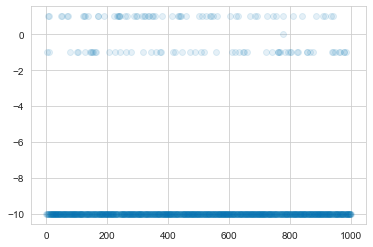

In [1018]:
rewards = []
for _ in tqdm(range(1000)):
    state = env.reset()
    done = False
    
    while not done:
        actions = env.getEmptySpaces()
        if env.curTurn == -1: # turn of naughts
            action = random.choice(actions)
        else:
            ind = np.argmax(q_table[state[0]])
            action = all_actions[ind]
        state, reward, done, info = env.step(action)
    rewards.append(reward)
    
plt.scatter(np.arange(0, len(rewards)), rewards, alpha=0.1)

## lets train q_table

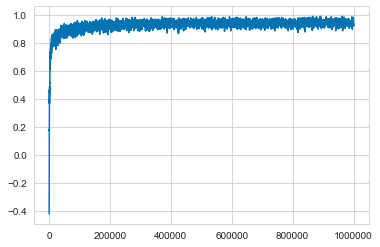

In [1019]:
rewards = []

# Hyperparameters
alpha = 0.2
gamma = 0.9
epsilon = 0.04

# For plotting metrics
for i in range(1, 1000001):
    state = env.reset()

    epochs, penalties, reward, = 0, 0, 0
    done = False
    cross_actions = []
    cross_states = []

    while not done:
        s, actions = env.getHash(), env.getEmptySpaces()
        if env.curTurn == -1: # turn of naughts
            action = random.choice(actions)
        else:
            
            if random.uniform(0, 1) < epsilon:
                action = random.choice(actions)
            else:
                while True:
                    ind = np.argmax(q_table[state[0]])
                    action = all_actions[ind]
                    
                    if action not in actions:
                        q_table[state[0]][indexof(all_actions, action)] = -1000
                    else:
                        break
            cross_actions.append(action)

        next_state, reward, done, info = env.step(action) 

        if done == False:
            reward = 0
        else:
            if env.curTurn == -1: # crosses win
                reward = 1
            else:
                reward = -1
                
            old_value = q_table[cross_states[-1]][indexof(all_actions, list(cross_actions[-1]))]
            next_max = np.max(q_table[next_state[0]])

            new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
            q_table[cross_states[-1]][indexof(all_actions, list(cross_actions[-1]))] = new_value

            state = next_state
        
        if env.curTurn == 1:
            cross_states.append(state[0])
            old_value = q_table[state[0]][indexof(all_actions, list(cross_actions[-1]))]
            next_max = np.max(q_table[next_state[0]])

            new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
            q_table[state[0]][indexof(all_actions, list(cross_actions[-1]))] = new_value


            state = next_state

    rewards.append(reward)
    
    if i % 10000 == 0:
        clear_output(wait=True)
        
        plt.figure()
        pd.Series(rewards).rolling(500).mean().plot()
        plt.show()
        plt.close()

## let's see how it improved

100%|██████████| 1000/1000 [00:00<00:00, 3506.56it/s]


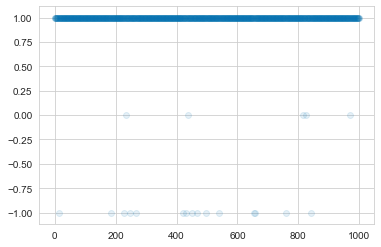

In [1020]:
rewards = []
for _ in tqdm(range(1000)):
    state = env.reset()
    done = False
    
    while not done:
        actions = env.getEmptySpaces()
        if env.curTurn == -1: # turn of naughts
            action = random.choice(actions)
        else:
            ind = np.argmax(q_table[state[0]])
            action = all_actions[ind]
        state, reward, done, info = env.step(action)
    rewards.append(reward)

plt.scatter(np.arange(0, len(rewards)), rewards, alpha=0.1)

# Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5.

In [1025]:
n_size = 4
env = TicTacToe(n_size,n_size,n_size)
env.reset()
all_actions  = env.getEmptySpaces().tolist()

q_table = defaultdict(lambda : np.random.uniform(size=n_size*n_size).tolist())

## lets test q_table before learning

100%|██████████| 1000/1000 [00:00<00:00, 1955.00it/s]


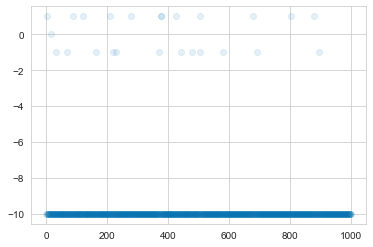

In [1026]:
rewards = []
for _ in tqdm(range(1000)):
    state = env.reset()
    done = False
    
    while not done:
        actions = env.getEmptySpaces()
        if env.curTurn == -1: # turn of naughts
            action = random.choice(actions)
        else:
            ind = np.argmax(q_table[state[0]])
            action = all_actions[ind]
        state, reward, done, info = env.step(action)
    rewards.append(reward)
    
plt.scatter(np.arange(0, len(rewards)), rewards, alpha=0.1)

## lets compare with pure random

100%|██████████| 1000/1000 [00:00<00:00, 1025.40it/s]


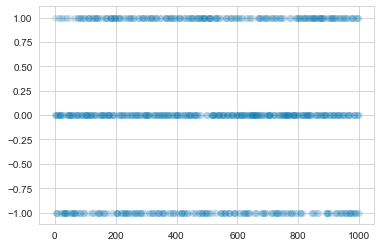

In [1027]:
rewards = []
for _ in tqdm(range(1000)):
    state = env.reset()
    done = False
    
    while not done:
        actions = env.getEmptySpaces()
        action = random.choice(actions)
        state, reward, done, info = env.step(action)
    rewards.append(reward)
    
plt.scatter(np.arange(0, len(rewards)), rewards, alpha=0.1)

## lets train q_table

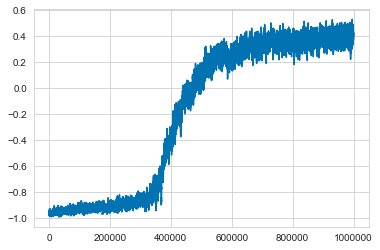

In [1028]:
rewards = []

# Hyperparameters
alpha = 0.2
gamma = 0.9
epsilon = 0.04

# For plotting metrics
for i in range(1, 1000001):
    state = env.reset()

    epochs, penalties, reward, = 0, 0, 0
    done = False
    cross_actions = []
    cross_states = []

    while not done:
        s, actions = env.getHash(), env.getEmptySpaces()
        if env.curTurn == -1: # turn of naughts
            action = random.choice(actions)
        else:
            
            if random.uniform(0, 1) < epsilon:
                action = random.choice(actions)
            else:
                while True:
                    ind = np.argmax(q_table[state[0]])
                    action = all_actions[ind]
                    
                    if action not in actions:
                        q_table[state[0]][indexof(all_actions, action)] = -1000
                    else:
                        break
            cross_actions.append(action)

        next_state, reward, done, info = env.step(action) 

        if done == False:
            reward = 0
        else:
            if env.curTurn == -1: # crosses win
                reward = 1
            else:
                reward = -1
                
            old_value = q_table[cross_states[-1]][indexof(all_actions, list(cross_actions[-1]))]
            next_max = np.max(q_table[next_state[0]])

            new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
            q_table[cross_states[-1]][indexof(all_actions, list(cross_actions[-1]))] = new_value

            state = next_state
        
        if env.curTurn == 1:
            cross_states.append(state[0])
            old_value = q_table[state[0]][indexof(all_actions, list(cross_actions[-1]))]
            next_max = np.max(q_table[next_state[0]])

            new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
            q_table[state[0]][indexof(all_actions, list(cross_actions[-1]))] = new_value


            state = next_state

    rewards.append(reward)
    
    if i % 10000 == 0:
        clear_output(wait=True)
        
        plt.figure()
        pd.Series(rewards).rolling(500).mean().plot()
        plt.show()
        plt.close()

## let's see how it improved

100%|██████████| 1000/1000 [00:00<00:00, 1682.79it/s]


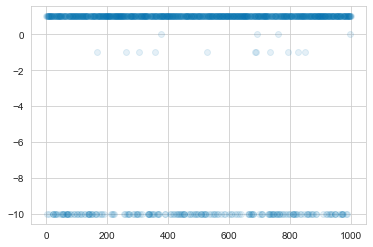

In [1029]:
rewards = []
for _ in tqdm(range(1000)):
    state = env.reset()
    done = False
    
    while not done:
        actions = env.getEmptySpaces()
        if env.curTurn == -1: # turn of naughts
            action = random.choice(actions)
        else:
            ind = np.argmax(q_table[state[0]])
            action = all_actions[ind]
        state, reward, done, info = env.step(action)
    rewards.append(reward)

plt.scatter(np.arange(0, len(rewards)), rewards, alpha=0.1)

# Реализуйте DQN с нейронной сетью, обучите стратегии крестиков и ноликов. Замечание: скорее всего, experience replay потребуется сразу же.

In [1030]:
class TicTacToeWrapper():
    """
    wrapper that imitates only one player with random response from opponent
    """
    def __init__(self, board_size, first_turn=True):
        self.board_size = board_size
        self.first_turn = first_turn
        
        self.env = TicTacToe(board_size, board_size, board_size)
        self.actions = self.env.getEmptySpaces().tolist()
        
        self.n_turns = 0
        
        if first_turn == False:
            assert False ,'not implemented'
            
    
    def step(self, action_index):
        state, reward, done, info = self.env.step(self.actions[action_index])
        self.n_turns += 1
        
        if not done:
            done = self.simulate_opponent()
            
            if done:
                # we lost
                return self.env.board, -1, True, info
            else:
                # play further
                return self.env.board, 0, False, {}
            
        else:
            if reward == -10:
                # wrong move
                return self.env.board, -10, True, info
            else:
                if self.n_turns == self.board_size * self.board_size:
                    # draw
                    return self.env.board, -0.5, True, info
                else:
                    # we won
                    return self.env.board, 1, True, info
        
            
    def simulate_opponent(self):
        actions = self.env.getEmptySpaces()
        action = random.choice(actions)
        state, reward, done, info = self.env.step(action)
        self.n_turns += 1
        return done
        
    def reset(self):
        self.n_turns = 0
        self.done = None
        if self.first_turn == False:
            assert False ,'not implemented'
        self.env.reset()
        return self.env.board, 0, False, {}

In [1032]:
class TicTacDQNetwork(nn.Module):
    def __init__(self, board_size):
        self.board_size = board_size
        nn.Module.__init__(self)
        self.conv1 = torch.nn.Conv2d(1, 16 , board_size, padding=(2,2))
        self.conv2 = torch.nn.Conv2d(16, 3 , board_size, padding=(2,2))
        self.l1 = nn.Linear(board_size * board_size * 3, board_size * board_size)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.l1(x.view(-1, self.board_size * self.board_size * 3))
        return x


class TicTacDQN():
    def __init__(self, board_size):
        self.board_size = board_size
        self.env = TicTacToeWrapper(board_size)
        self.model = TicTacDQNetwork(board_size)
        self.memory = ReplayMemory(10000)
        self.optimizer = optim.Adam(self.model.parameters(), 0.001)
        self.steps_done = 0
        self.episode_durations = []
        
        self.gamma = 0.8
        self.batch_size = 64
        
        self.eps_init, self.eps_final, self.eps_decay = 0.9, 0.05, 200
        self.num_step = 0
        self.rewards = []

    def select_greedy_action(self, state):
        return self.model(state).data.max(1)[1].view(1, 1)

    def select_action(self, state):
        sample = random.random()
        self.num_step += 1
        eps_threshold = self.eps_final + (self.eps_init - self.eps_final) * math.exp(-1. * self.num_step / self.eps_decay)
        if sample > eps_threshold:
            return self.select_greedy_action(state)
        else:
            return torch.tensor([[random.randrange(self.board_size * self.board_size)]], dtype=torch.int64)
        
    def run_episode(self, e=0, do_learning=True, greedy=False):
        state, reward, done, info  = self.env.reset()
        num_step = 0
        while True:

            state_tensor = torch.tensor(state, dtype=torch.float32).reshape(1,1,self.board_size, self.board_size)
            with torch.no_grad():
                if greedy:
                    action = self.select_greedy_action(state_tensor)
                else:
                    action = self.select_action(state_tensor)
                    
            next_state, reward, done, _ = self.env.step(action.numpy()[0][0])
            next_state_tensor = torch.tensor(next_state, dtype=torch.float32).reshape(1,1,self.board_size, self.board_size)

            transition = (state_tensor, action, next_state_tensor, torch.tensor([reward], dtype=torch.float32))
            self.memory.store(transition)

            if do_learning:
                self.learn()

            state = next_state
            num_step += 1

            if done:
                self.episode_durations.append(num_step)
                self.rewards.append(reward)
                break

    def learn(self):
        if len(self.memory) < self.batch_size:
            return

        # берём мини-батч из памяти
        transitions = self.memory.sample(self.batch_size)
        batch_state, batch_action, batch_next_state, batch_reward = zip(*transitions)

        batch_state = Variable(torch.cat(batch_state))
        batch_action = Variable(torch.cat(batch_action))
        batch_reward = Variable(torch.cat(batch_reward))
        batch_next_state = Variable(torch.cat(batch_next_state))

        # считаем значения функции Q
        Q = self.model(batch_state).gather(1, batch_action).reshape([self.batch_size])

        # оцениваем ожидаемые значения после этого действия
        Qmax = self.model(batch_next_state).detach().max(1)[0]
        Qnext = batch_reward + (self.gamma * Qmax)

        # и хотим, чтобы Q было похоже на Qnext -- это и есть суть Q-обучения
        loss = F.smooth_l1_loss(Q, Qnext)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [1035]:
tictac_dqn = TicTacDQN(5)

100%|██████████| 1000/1000 [00:04<00:00, 229.21it/s]


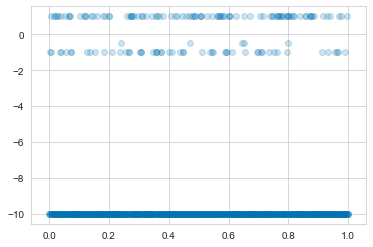

In [1040]:
wins = []
for i in tqdm(range(1000)):
    tictac_dqn.run_episode(e=0, greedy=True, do_learning=False)
    reward = tictac_dqn.rewards[-1]
    wins.append(reward)

plt.scatter(np.linspace(0, 1, len(wins)), wins, alpha=0.2)

In [1041]:
for i in tqdm(range(30000)):
    tictac_dqn.run_episode(e=0.04)    

100%|██████████| 30000/30000 [13:02<00:00, 38.32it/s]


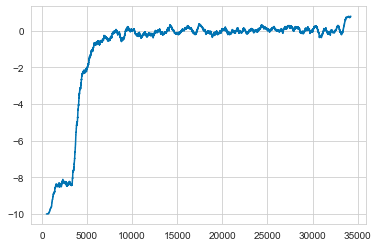

In [1044]:
pd.Series(tictac_dqn.rewards).rolling(500).mean().plot()

100%|██████████| 1000/1000 [00:02<00:00, 367.94it/s]


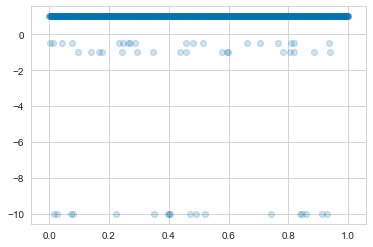

In [1043]:
wins = []
for i in tqdm(range(1000)):
    tictac_dqn.run_episode(e=0, greedy=True, do_learning=False)
    reward = tictac_dqn.rewards[-1]
    wins.append(reward)

plt.scatter(np.linspace(0, 1, len(wins)), wins, alpha=0.2)

# Реализуйте Double DQN и/или Dueling DQN.

In [1049]:
class TicTacDuelingDQNetwork(nn.Module):

    def __init__(self, board_size):
        super(TicTacDuelingDQNetwork, self).__init__()
        
        self.board_size = board_size
        
        self.conv = nn.Sequential(
            nn.Conv2d(1, 5, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(5, 3, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
#             nn.Conv2d(32, 64, kernel_size=4, stride=2),
#             nn.ReLU(),
#             nn.Conv2d(64, 64, kernel_size=3, stride=1),
#             nn.ReLU()
        )
        
        self.fc_input_dim = self.feature_size()
        
        self.value_stream = nn.Sequential(
            nn.Linear(self.fc_input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

        self.advantage_stream = nn.Sequential(
            nn.Linear(self.fc_input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, self.board_size * self.board_size)
        )

    def forward(self, state):
        features = self.conv(state)
        features = features.view(features.size(0), -1)
        values = self.value_stream(features)
        advantages = self.advantage_stream(features)
        qvals = values + (advantages - advantages.mean())
        
        return qvals

    def feature_size(self):
        return self.conv(torch.zeros(1, 1, self.board_size, self.board_size)).view(1, -1).size(1)


# https://towardsdatascience.com/dueling-deep-q-networks-81ffab672751
class TicTacDuelingDQN():
    def __init__(self, board_size):
        self.board_size = board_size
        self.env = TicTacToeWrapper(board_size)
        self.model = TicTacDuelingDQNetwork(board_size)
        self.memory = ReplayMemory(10000)
        self.optimizer = optim.Adam(self.model.parameters(), 0.001)
        self.steps_done = 0
        self.episode_durations = []
        
        self.gamma = 0.8
        self.batch_size = 64
        
        self.eps_init, self.eps_final, self.eps_decay = 0.9, 0.05, 200
        self.num_step = 0
        self.rewards = []

    def select_greedy_action(self, state):
        return self.model(state).data.max(1)[1].view(1, 1)
    
#     def select_random_action(self):
        
    

    def select_action(self, state):
        sample = random.random()
        self.num_step += 1
        eps_threshold = self.eps_final + (self.eps_init - self.eps_final) * math.exp(-1. * self.num_step / self.eps_decay)
        if sample > eps_threshold:
            return self.select_greedy_action(state)
        else:
            return torch.tensor([[random.randrange(self.board_size * self.board_size)]], dtype=torch.int64)
        
    def run_episode(self, e=0, do_learning=True, greedy=False):
        state, reward, done, info  = self.env.reset()
        num_step = 0
        while True:

            state_tensor = torch.tensor(state, dtype=torch.float32).reshape(1,1,self.board_size, self.board_size)
            with torch.no_grad():
                if greedy:
                    action = self.select_greedy_action(state_tensor)
                else:
                    action = self.select_action(state_tensor)
                    
            next_state, reward, done, _ = self.env.step(action.numpy()[0][0])
            next_state_tensor = torch.tensor(next_state, dtype=torch.float32).reshape(1,1,self.board_size, self.board_size)

            transition = (state_tensor, action, next_state_tensor, torch.tensor([reward], dtype=torch.float32))
            self.memory.store(transition)

            if do_learning:
#                 if random.random() < 0.05 and len(self.memory) > 256:
#                     self.rebalance()
                self.learn()

            state = next_state
            num_step += 1

            if done:
#                 print("\tepisode %d finished after %d steps" % (e, num_step))
                self.episode_durations.append(num_step)
                self.rewards.append(reward)
                break
            
    def rebalance(self):
        batch_size = 256
        data = self.memory.memory
        diffs = []
        
        
        with torch.no_grad():
            for i in range((len(data) // batch_size) + 1):
                batch = data[i*batch_size:(i+1)*batch_size]
#                 print(len(batch))
                batch_state, batch_action, batch_next_state, batch_reward = zip(*batch)
                
                
                batch_state = Variable(torch.cat(batch_state))
                batch_action = Variable(torch.cat(batch_action))
                batch_reward = Variable(torch.cat(batch_reward))
                batch_next_state = Variable(torch.cat(batch_next_state))

                # считаем значения функции Q
#                 print(batch_state.shape)
                Q = self.model(batch_state).gather(1, batch_action).reshape([len(batch)])

                # оцениваем ожидаемые значения после этого действия
                Qmax = self.model(batch_next_state).detach().max(1)[0]
                Qnext = batch_reward + (self.gamma * Qmax)
                
                diff = F.mse_loss(Q, Qnext, reduction='none').numpy()
                diffs.extend(diff.tolist())
                print(diff)
        self.memory.set_weights(diffs)

    def learn(self):
        if len(self.memory) < self.batch_size:
            return

        # берём мини-батч из памяти
        transitions = self.memory.sample(self.batch_size)
        batch_state, batch_action, batch_next_state, batch_reward = zip(*transitions)

        batch_state = Variable(torch.cat(batch_state))
        batch_action = Variable(torch.cat(batch_action))
        batch_reward = Variable(torch.cat(batch_reward))
        batch_next_state = Variable(torch.cat(batch_next_state))

        # считаем значения функции Q
        Q = self.model(batch_state).gather(1, batch_action).reshape([self.batch_size])

        # оцениваем ожидаемые значения после этого действия
        Qmax = self.model(batch_next_state).detach().max(1)[0]
        Qnext = batch_reward + (self.gamma * Qmax)

        # и хотим, чтобы Q было похоже на Qnext -- это и есть суть Q-обучения
        loss = F.smooth_l1_loss(Q, Qnext)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [1054]:
tictac_ddqn = TicTacDuelingDQN(5)

100%|██████████| 1000/1000 [00:01<00:00, 523.17it/s]


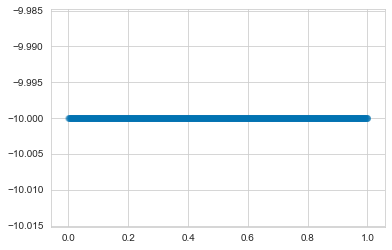

In [1055]:
wins = []
for i in tqdm(range(1000)):
    tictac_ddqn.run_episode(e=0, greedy=True, do_learning=False)
    reward = tictac_ddqn.rewards[-1]
    wins.append(reward)

plt.scatter(np.linspace(0, 1, len(wins)), wins, alpha=0.2)

In [1056]:
for i in tqdm(range(30000)):
    tictac_ddqn.run_episode(e=0.05) 

100%|██████████| 30000/30000 [18:50<00:00, 26.54it/s]


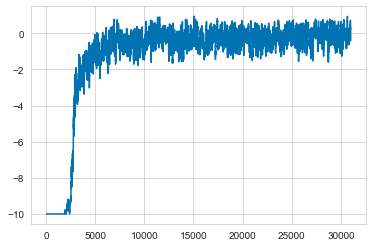

In [1057]:
pd.Series(tictac_ddqn.rewards).rolling(50).mean().plot()

100%|██████████| 1000/1000 [00:03<00:00, 289.64it/s]


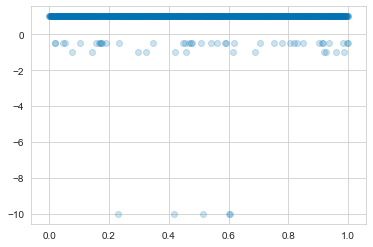

In [1058]:
wins = []
for i in tqdm(range(1000)):
    tictac_ddqn.run_episode(e=0, greedy=True, do_learning=False)
    reward = tictac_ddqn.rewards[-1]
    wins.append(reward)

plt.scatter(np.linspace(0, 1, len(wins)), wins, alpha=0.2)

# Реализуйте rollouts со случайной стратегией и (опционально) rollouts с неслучайной, но простой стратегией (например, основанной на дополнении нескольких паттернов или на Q-функции, которая у вас получилась в первом пункте).

In [1059]:
from copy import deepcopy

In [1060]:
def rollout(env, random_strategy=True, max_depth=None, play_as_crosses=True):
    assert random_strategy == True, 'not implemented'
    
    env = deepcopy(env)
    done = env.isTerminal() is not None
    
    while not done:
        action = random.choice(env.emptySpaces)
        state, reward, done, info = env.step(action)
        
    if play_as_crosses == False:
        reward = -reward
    return reward

In [1065]:
env = TicTacToe(3,3,3)

In [1066]:
env.reset()

env.step([0,0]) #x
env.step([1,2]) #o
env.step([2,2]) #x
env.step([1,1]) #o

env.board

array([[ 1,  0,  0],
       [ 0, -1, -1],
       [ 0,  0,  1]])

In [1067]:
np.mean([rollout(env) for _ in range(10000)])

-0.0954

In [1068]:
env.reset()

env.step([1,1])
env.step([0,0])

env.board

array([[-1,  0,  0],
       [ 0,  1,  0],
       [ 0,  0,  0]])

In [1069]:
np.mean([rollout(env) for _ in range(10000)])

0.4279

# Реализуйте MCTS-поиск с этими rollouts для крестиков-ноликов на досках разного размера, сравните полученные стратегии между собой и со стратегиями, обученными в первых двух частях.

In [1070]:
from itertools import chain

class Node:
    def __init__(self, env, parent=None, my_turn=True):
        self.my_turn = my_turn
        self.env = env
        self.parent = None
        self.children = []
        self.action = None
        self.terminal = False
        self.reward = None
        
        self.num_sim = 1
        self.num_win = 1
        
        if parent is not None:
            self.parent = parent
            parent.children.append(self)
            
    @property
    def ucb(self):
        return (self.num_win / self.num_sim) + 2 * \
                    np.sqrt((np.log(self.parent.num_sim if self.parent is not None else self.num_sim) /
                    self.num_sim))

    def win(self):
        self.done(win=True)
        
    def loss(self):
        self.done(win=False)
        
    def done(self, win=False, propagate=True, update_num_sim=True):
        self.num_win += 1 if win else 0
        if update_num_sim: self.num_sim += 1
        
        if propagate:
            parent = self.parent
            while parent is not None:
                parent.num_win += 1 if win else 0
                if update_num_sim: parent.num_sim += 1
                parent = parent.parent
                
    def __repr__(self):
        repr = \
        """
node:        {node_id}
parent_node: {parent_node}
num_sim:     {num_sim}
num_win:     {num_win}
action:      {action}
ucb:         {ucb}
my_turn:     {my_turn}
terminal:    {terminal}
reward:      {reward}
board:
{board}
children:
{children_repr}
        """.format(
            node_id=id(self),
            parent_node='none' if self.parent is None else id(self.parent),
            num_sim=self.num_sim,
            num_win=self.num_win,
            children_repr='\n'.join(chain(*[['\n'.join(['|    ' + line for line in str(child).split('\n')])] 
                                     for child in self.children])),
            action='' if self.action is None else str(self.action),
            ucb=self.ucb,
            my_turn=str(self.my_turn),
            terminal=str(self.terminal),
            reward=str(self.reward),
            board=str(self.env.board)
        )
        return repr
    

def select_node(node):
    while len(node.children) > 0:
        if node.my_turn:
            node = max(node.children, key=lambda x: x.ucb)
        else:
            node = random.choice(node.children)
        
    return node



def expand_node(node):
    for action in node.env.emptySpaces.tolist():
        action_env = deepcopy(node.env)
        _, r, done, _ = action_env.step(action)
        
        new_node = Node(action_env, node, my_turn=not node.my_turn)
        new_node.action = action
        if done:
            new_node.terminal = True
            new_node.reward = r

def mcts(env, num_sim=10):
    tree = Node(deepcopy(env))
    
    assert env.isTerminal() is None
    
    for _ in range(num_sim):
        node = select_node(tree)
        
        if node.terminal:
            if node.reward > 0:
                node.win()
            else:
                node.loss()
                
            continue
        
        expand_node(node)
        
        node = random.choice(node.children)
        
        if node.terminal:
            if node.reward > 0:
                node.win()
            else:
                node.loss()
                
            continue
        else:
            rol = rollout(node.env)
            if rol > 0:
                node.win()
            else:
                node.loss()
    
    best_action_node = max(tree.children, key=lambda x: x.num_sim)
    best_action = best_action_node.action
    best_action_stats = best_action_node.num_win, best_action_node.num_sim
    return tree, best_action, best_action_stats

    
    return tree
        
    
    

In [1072]:
_ = env.reset()

env.step([0,0])
env.step([0,1])

env.step([1,2])
env.step([1,1])

env.step([2,1])
env.step([0,2])

env.board

array([[ 1, -1, -1],
       [ 0, -1,  1],
       [ 0,  1,  0]])

In [1073]:
print(str(env.board))

[[ 1 -1 -1]
 [ 0 -1  1]
 [ 0  1  0]]


In [1074]:
%%time
tree, best_action, action_stats = mcts(env, num_sim=30)

best_action, action_stats

CPU times: user 3.02 ms, sys: 136 µs, total: 3.16 ms
Wall time: 3.06 ms


([2, 0], (16, 16))

In [1075]:
tree


node:        5468546608
parent_node: none
num_sim:     31
num_win:     24
action:      
ucb:         1.4398474548275035
my_turn:     True
terminal:    False
reward:      None
board:
[[ 1 -1 -1]
 [ 0 -1  1]
 [ 0  1  0]]
children:
|    
|    node:        5444640720
|    parent_node: 5468546608
|    num_sim:     9
|    num_win:     5
|    action:      [1, 0]
|    ucb:         1.7909569216413843
|    my_turn:     False
|    terminal:    False
|    reward:      None
|    board:
|    [[ 1 -1 -1]
|     [ 1 -1  1]
|     [ 0  1  0]]
|    children:
|    |    
|    |    node:        5445213152
|    |    parent_node: 5444640720
|    |    num_sim:     5
|    |    num_win:     1
|    |    action:      [2, 0]
|    |    ucb:         1.5258128306322034
|    |    my_turn:     True
|    |    terminal:    True
|    |    reward:      -1
|    |    board:
|    |    [[ 1 -1 -1]
|    |     [ 1 -1  1]
|    |     [-1  1  0]]
|    |    children:
|    |    
|    |            
|    |    
|    |    node:        544

# Реализуйте AlphaZero для крестиков-ноликов, используя MCTS из третьей части и DQN-сеть из второй части. Обучите стратегии для игры на больших досках (10х10 и выше, до пяти в ряд; опять же, может потребовать много времени, так что достаточно показать, что обучение началось и идёт).


руководствовался этой статьей 
https://web.stanford.edu/~surag/posts/alphazero.html
    
реализовал mcts поиск и использованием V(s), проигрывание эпизода с использованием поиска
в ход противника доска инвертится, то есть 1 превращается в -1 и наоборот
затем идет обучение сетки на сгенерированных примерах
генерацию примеров с поиском распараллелил

тестировал на 5х5, т.к. жалко ноут
как видно в конце, процент выиграша против рандомного соперника улучшается

In [8]:
from copy import deepcopy
from itertools import chain
from math import sqrt

from tqdm.notebook import tqdm
import multiprocessing


In [9]:
def transform_board(board):
    '''
    переделаем представление доски в более удобное для сверточной сетки
    '''
    new_board = np.zeros(shape=(3, board_size, board_size))
    new_board[0, board == -1] = 1
    new_board[1, board == 1] = 1
    new_board[2, np.abs(board) == 1] = 1
    return new_board

In [45]:
class TicTacDuelingDQNetwork(nn.Module):
    def __init__(self, board_size):
        super(TicTacDuelingDQNetwork, self).__init__()
        
        self.board_size = board_size
        
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )
        
        self.fc_input_dim = self.feature_size()
        
        self.value_stream = nn.Sequential(
            nn.Linear(self.fc_input_dim + ((board_size**2) * 3), 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

        self.advantage_stream = nn.Sequential(
            nn.Linear(self.fc_input_dim + ((board_size**2) * 3), 64),
            nn.ReLU(),
            nn.Linear(64, self.board_size * self.board_size),
            nn.Softmax(dim=1)
            # softmax()?
        )

    def forward(self, state):
        features = self.conv(state)
        features = features.view(features.size(0), -1)
        features = torch.cat([features, state.view(features.size(0), -1)], dim=1)
#         print(features.size())
        values = self.value_stream(features)
        advantages = self.advantage_stream(features)
        qvals = values + (advantages - advantages.mean())
        
        return qvals
    
    def get_v_p(self, state):
        with torch.no_grad():
            state = torch.FloatTensor(state).view(1,3,self.board_size, self.board_size)
            features = self.conv(state)
            features = features.view(features.size(0), -1)
            features = torch.cat([features, state.view(features.size(0), -1)], dim=1)
            value = self.value_stream(features)
            advantages = self.advantage_stream(features) 
            return value.numpy().squeeze().item(), advantages.numpy().squeeze().tolist()
    
    def get_values(self, states_batch):
        features = self.conv(states_batch.view(states_batch.size(0), 3, self.board_size, self.board_size))
        features = features.view(features.size(0), -1)
        features = torch.cat([features, states_batch.view(features.size(0), -1)], dim=1)
        values = self.value_stream(features)
        advantages = self.advantage_stream(features) 
        return values, advantages
    
    def get_action(self, board):
        with torch.no_grad():
            x = torch.FloatTensor(board).view(1, 3, self.board_size, self.board_size)
            features = self.conv(x).view(1, -1)
            features = torch.cat([features, x.view(features.size(0), -1)], dim=1)
            advantages = self.advantage_stream(features) * ((1 - x[0,2,:,:])).view(features.size(0), -1)

            return advantages.numpy().argmax()
        

    def feature_size(self):
        return self.conv(torch.zeros(1, 3, self.board_size, self.board_size)).view(1, -1).size(1)


In [50]:
class MCTSNNode:
    def __init__(self, env, parent=None, my_turn=True, nnet=None):
        self.my_turn = my_turn
        self.env = env
        self.parent = None
        self.children = []
        self.action = None
        self.terminal = False
        self.reward = None
        self.visited = False
        
        self.num_sim = 0
        
        if parent is not None:
            self.parent = parent
            parent.children.append(self)
            self.nnet = self.parent.nnet
            self.my_turn = not self.parent.my_turn
        else:
            assert nnet is not None
            self.nnet = nnet
            
        self.q_value = 0 # estimated by simulation
        self.c_const = 1 # parameter
        self.policy = None
        self.initial_policy_value = None # got from nnet
        
    def search(self):
        if self.terminal: 
            self.q_value = (self.q_value * self.num_sim + self.reward) / (self.num_sim + 1)
            self.num_sim += 1
            return -self.reward
        
        if not self.visited:
            self.visited = True
            
            if not self.my_turn:
                state = -self.env.board
            else:
                state = self.env.board
            self.reward, self.policy = self.nnet.get_v_p(transform_board(state))

            for action in self.env.emptySpaces:
                action_env = deepcopy(self.env)
                s, r, d, _ = action_env.step(action)
                new_node = MCTSNNode(action_env, parent=self)
                new_node.action = action
                new_node.action_ind = action_to_action_ind[tuple(action)]
                new_node.initial_policy_value = self.policy[new_node.action_ind]
                
                if d:
                    new_node.terminal = True
                    
                    new_node.reward = r
                    new_node.num_sim += 1
                    
                    if new_node.my_turn is True:
                        new_node.reward *= -1
            
            self.q_value = (self.q_value * self.num_sim + self.reward) / (self.num_sim + 1)
            self.num_sim += 1
            return -self.reward
        
        best_action_node = max(self.children, key=lambda x: x.ucb)
        v = best_action_node.search()
        
        self.q_value = (self.q_value * self.num_sim + v) / (self.num_sim + 1)
        self.num_sim += 1
        
        return -v
    
    def get_policy(self):
        policy = [0] * self.nnet.board_size * self.nnet.board_size
        n_total = 0.000001
        for child_node in self.children:
            action_ind = child_node.action_ind
            child_n = child_node.num_sim
            policy[action_ind] = child_n 
            n_total += child_n
        policy = [x/n_total for x in policy]
        return policy
            
    @property
    def ucb(self):
        if self.parent is None: return 0
        return self.q_value + self.c_const * sqrt(self.initial_policy_value+1) * (sqrt(self.parent.num_sim) / (1 + self.num_sim))
                
    def print(self, max_d=None, d=0):
        if max_d is not None and d > max_d:return ''
        repr = \
        """
node:        {node_id}
parent_node: {parent_node}
num_sim:     {num_sim}
q_value:     {q_value}
reward:      {reward}
action:      {action}
ucb:         {ucb}
my_turn:     {my_turn}
terminal:    {terminal}
reward:      {reward}
nnet_policy: {policy}
board:
{board}
children:
{children_repr}
        """.format(
            node_id=id(self),
            parent_node='none' if self.parent is None else id(self.parent),
            num_sim=self.num_sim,
            num_win=self.q_value,
            children_repr='\n'.join(chain(*[['\n'.join(['|    ' + line for line in child.print(max_d, d+1).split('\n')])] 
                                     for child in self.children])),
            action='' if self.action is None else str(self.action),
            ucb=self.ucb,
            my_turn=str(self.my_turn),
            terminal=str(self.terminal),
            reward=str(self.reward),
            board=str(self.env.board) if self.my_turn else str(-self.env.board),
            q_value=self.q_value,
            policy=str(self.initial_policy_value)
        )
        
        if d == 0:
            print(repr)
        else:
            return repr
    

In [68]:
def execute_episode(env_class, nnet, num_mcts_sim=100, num_rand_moves=4):
    env = env_class(5, 5, 5)
    env.reset()
    examples = []
    
    for _ in range(num_rand_moves):
        _, r, d, _ = env.step(random.choice(env.emptySpaces))
    
    root = MCTSNNode(deepcopy(env), nnet=deepcopy(nnet)  )
    
    done = False
    node = root
    while not done:
        for _ in range(num_mcts_sim):
            node.search()
            
        p = np.array(node.get_policy())
        action_ind = np.random.choice(np.arange(len(p)), p=(p / p.sum()))
        action = list(action_ind_to_action[action_ind])
        
        best_action_node = [x for x in node.children if x.action_ind == action_ind][0]

    
        if node.my_turn:
            examples.append([transform_board(node.env.board), node.get_policy()])
        else:
            examples.append([transform_board(-node.env.board), node.get_policy()])
            
        state, r, done, _ = env.step(action)
            
        
        node = best_action_node
        
    exx = []
    for i, x in enumerate(examples):
        m = 1 if i % 2 == 0 else -1
        exx.append([x[0], x[1], r * m])
#     examples = [[x[0], x[1], r] for x in examples]
    
    return exx
    return r, root

In [61]:
def train_net(nnet, optim, examples, num_iter, batch_size=128):
    losses = []
    for _ in range(num_iter):
        batch = random.sample(examples, batch_size)
        
        
        batch_state, batch_action, batch_reward = zip(*batch)

        batch_state = torch.FloatTensor(batch_state).view(batch_size, 3, board_size, board_size)
        batch_policies = torch.FloatTensor(batch_action).view(batch_size, 1, board_size*board_size)
        batch_reward = torch.FloatTensor(batch_reward).view(batch_size, 1)
        
        predicted_values, predicted_policies = nnet.get_values(batch_state)
        
        policy_addition = torch.matmul(batch_policies, torch.log(predicted_policies).view(batch_size, board_size*board_size, 1))
        loss = torch.pow(predicted_values - batch_reward, 2) - policy_addition
        loss = loss.mean()

        optim.zero_grad()
        loss.backward()
        optim.step()
        losses.append(loss.detach().numpy().item())
    return losses
        
    

In [14]:
def pit(env, new_nnet, old_nnet, num_games=1000, old_random=False, show=False, temp=0.1, num_rand_moves=0):
    
    wins = 1 # wins and losses of new net 
    losses = 1
    for i in range(num_games):
        rand_moves = num_rand_moves
        
        turn_of_new_nnet = i % 2 == 0
        invert_board = not turn_of_new_nnet
        
        state = env.reset()
        done = False
        while not done:
            
            board = env.board
            if invert_board:
                board = -board
                
            if rand_moves > 0:
                rand_moves -= 1
                action = random.choice(env.emptySpaces)
            else:
                if random.random() < temp:
                    action = random.choice(env.emptySpaces)
                else:
                    if turn_of_new_nnet:
                        action_ind = new_nnet.get_action(transform_board(board))
                        action = list(action_ind_to_action[action_ind])

                    else:
                        if old_random:
                            action = random.choice(env.emptySpaces)
                        else:
                            action_ind = old_nnet.get_action(transform_board(board))
                            action = list(action_ind_to_action[action_ind])
                
            
            if show:
                print(env.board, action)
                print()
            
            state, r, done, _ = env.step(action)
            turn_of_new_nnet = not turn_of_new_nnet
            invert_board = not invert_board
        if show:
            print(r)
            break
        
        if i % 2 == 0:
            if r > 0:
                wins += 1
            elif r < 0:
                losses += 1
        else:
            if r < 0:
                wins += 1
            elif r > 0:
                losses += 1
                
            
    return wins / (wins + losses)
                
    

In [15]:
board_size = 5
win_size = 5

env = TicTacToe(board_size, board_size, win_size)
env.reset()

action_to_action_ind = {tuple(a):i for i,a in enumerate(env.emptySpaces)}
action_ind_to_action = {v:k for k,v in action_to_action_ind.items()}

nnet = TicTacDuelingDQNetwork(board_size)

In [70]:
def pool_func(tup):
    env, nnet, num_sim = tup
    res = execute_episode(env, nnet, num_mcts_sim=num_sim, num_rand_moves=6)
    return res

In [127]:
fracs = []
examples_big = []
nets = []
losses = []

for i in tqdm(range(50), desc='num_iter'):
    examples = []

    num_epi = 1000
    with multiprocessing.Pool(6) as pool:
        res = list(tqdm(pool.imap(pool_func, [(env.__class__, nnet, 50)] * num_epi, chunksize=1),  total=num_epi, leave=False))
    examples.extend(list(chain.from_iterable(res)))
        
    nnet2 = deepcopy(nnet)
    optim = torch.optim.SGD(nnet2.parameters(), lr=0.01, weight_decay=0.00001, nesterov=False)
    for _ in tqdm(range(20000), leave=False, desc='training'):
        losses.append(train_net(nnet2, optim, examples, 1, batch_size=512))
        
#     frac_win = pit(env, nnet2, nnet, num_games=3000, temp=0.1, num_rand_moves=1)
    nets.append(deepcopy(nnet))
    nnet = deepcopy(nnet2)
    examples_big.append(examples)
        
    
        


KeyboardInterrupt: 

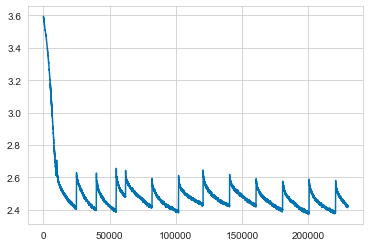

In [128]:
pd.Series([x[0] for x in losses]).rolling(100).mean().plot()

In [73]:
random_net = TicTacDuelingDQNetwork(board_size)

In [131]:
# сразим полученную сеть с рандомными ходами противника, как видно результат улучшается

for nnet in nets + [nnet2]:
    print(pit(env, nnet, random_net, old_random=True, num_games=3000, show=False, num_rand_moves=6, temp=0.05))

0.5496074232690935
0.5481540930979133
0.5555555555555556
0.6621405750798722
0.7410236822001528
0.8319763138415989
0.8509719222462203
0.8525490196078431
0.8674521354933726
0.8573573573573574
0.8786791098348887
0.8716814159292036
0.8782479584261321
